In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from scipy import stats
from utils import read_from_file


# Compute the CIs

In [2]:
dataset_name = ["bike", "blog_data", "community", "concrete", "facebook_2", "star"]
mean_lower = []
mean_upper = []
overall_mean = []

for dataset in dataset_name:

    model = "vime"

    lowers=[]
    uppers=[]
    pvals = []

    for i in range(5):
  
        # Paths to get the pickle files
        model = "vime"
        path1 = f"../dists/{dataset}_{i}_{model}.p"
        model = "crf"
        path2 = f"../dists/{dataset}_{i}_{model}.p"

        # compute the difference between SSCP and CRF
        metric_sc = read_from_file(path2)-read_from_file(path1)

        # compute the confidence interval --- upper and lower
        alpha=0.9 # 90% confidence interval
        lower = st.t.interval(alpha=alpha, df=len(metric_sc)-1, loc=np.mean(metric_sc), scale=st.sem(metric_sc))[0]
        upper = st.t.interval(alpha=alpha, df=len(metric_sc)-1, loc=np.mean(metric_sc), scale=st.sem(metric_sc))[1]
        
        # append for the run
        lowers.append(lower)
        uppers.append(upper)

    
    lowers, uppers = np.array(lowers), np.array(uppers)

    # z-score outliers
    z_cut=2
    if dataset == "blog_data" or dataset == "community" or dataset == "concrete" :
        z_cut=1
    lower_idx = (np.abs(stats.zscore(lowers)) < z_cut)
    upper_idx = (np.abs(stats.zscore(uppers)) < z_cut)

    if np.sum(lower_idx)>np.sum(upper_idx):
        lower_idx = upper_idx
    elif np.sum(lower_idx)<np.sum(upper_idx):
        upper_idx = lower_idx
        

    lowers = lowers[lower_idx]
    uppers = uppers[upper_idx]

    mean_lower.append(np.mean(lowers)) # lower
    mean_upper.append(np.mean(uppers)) # upper
    overall_mean.append((np.mean(uppers)+np.mean(lowers))/2) # midpoint of interval

bike 0.016027560889684263 0.03483328585144072 0.02543042337056249 5 5
blog_data 0.0030657969164592305 0.07416710548746164 0.03861645120196043 4 4
community 0.08721690120807857 0.1813306393224838 0.1342737702652812 3 3
concrete 0.036079928688668376 0.07504568114880407 0.05556280491873622 4 4
facebook_2 0.012468460189267182 0.09666139484746834 0.054564927518367765 5 5
star 0.022051964429722716 0.037081096033050126 0.02956653023138642 5 5


# Plot the robustness study eval of CIs

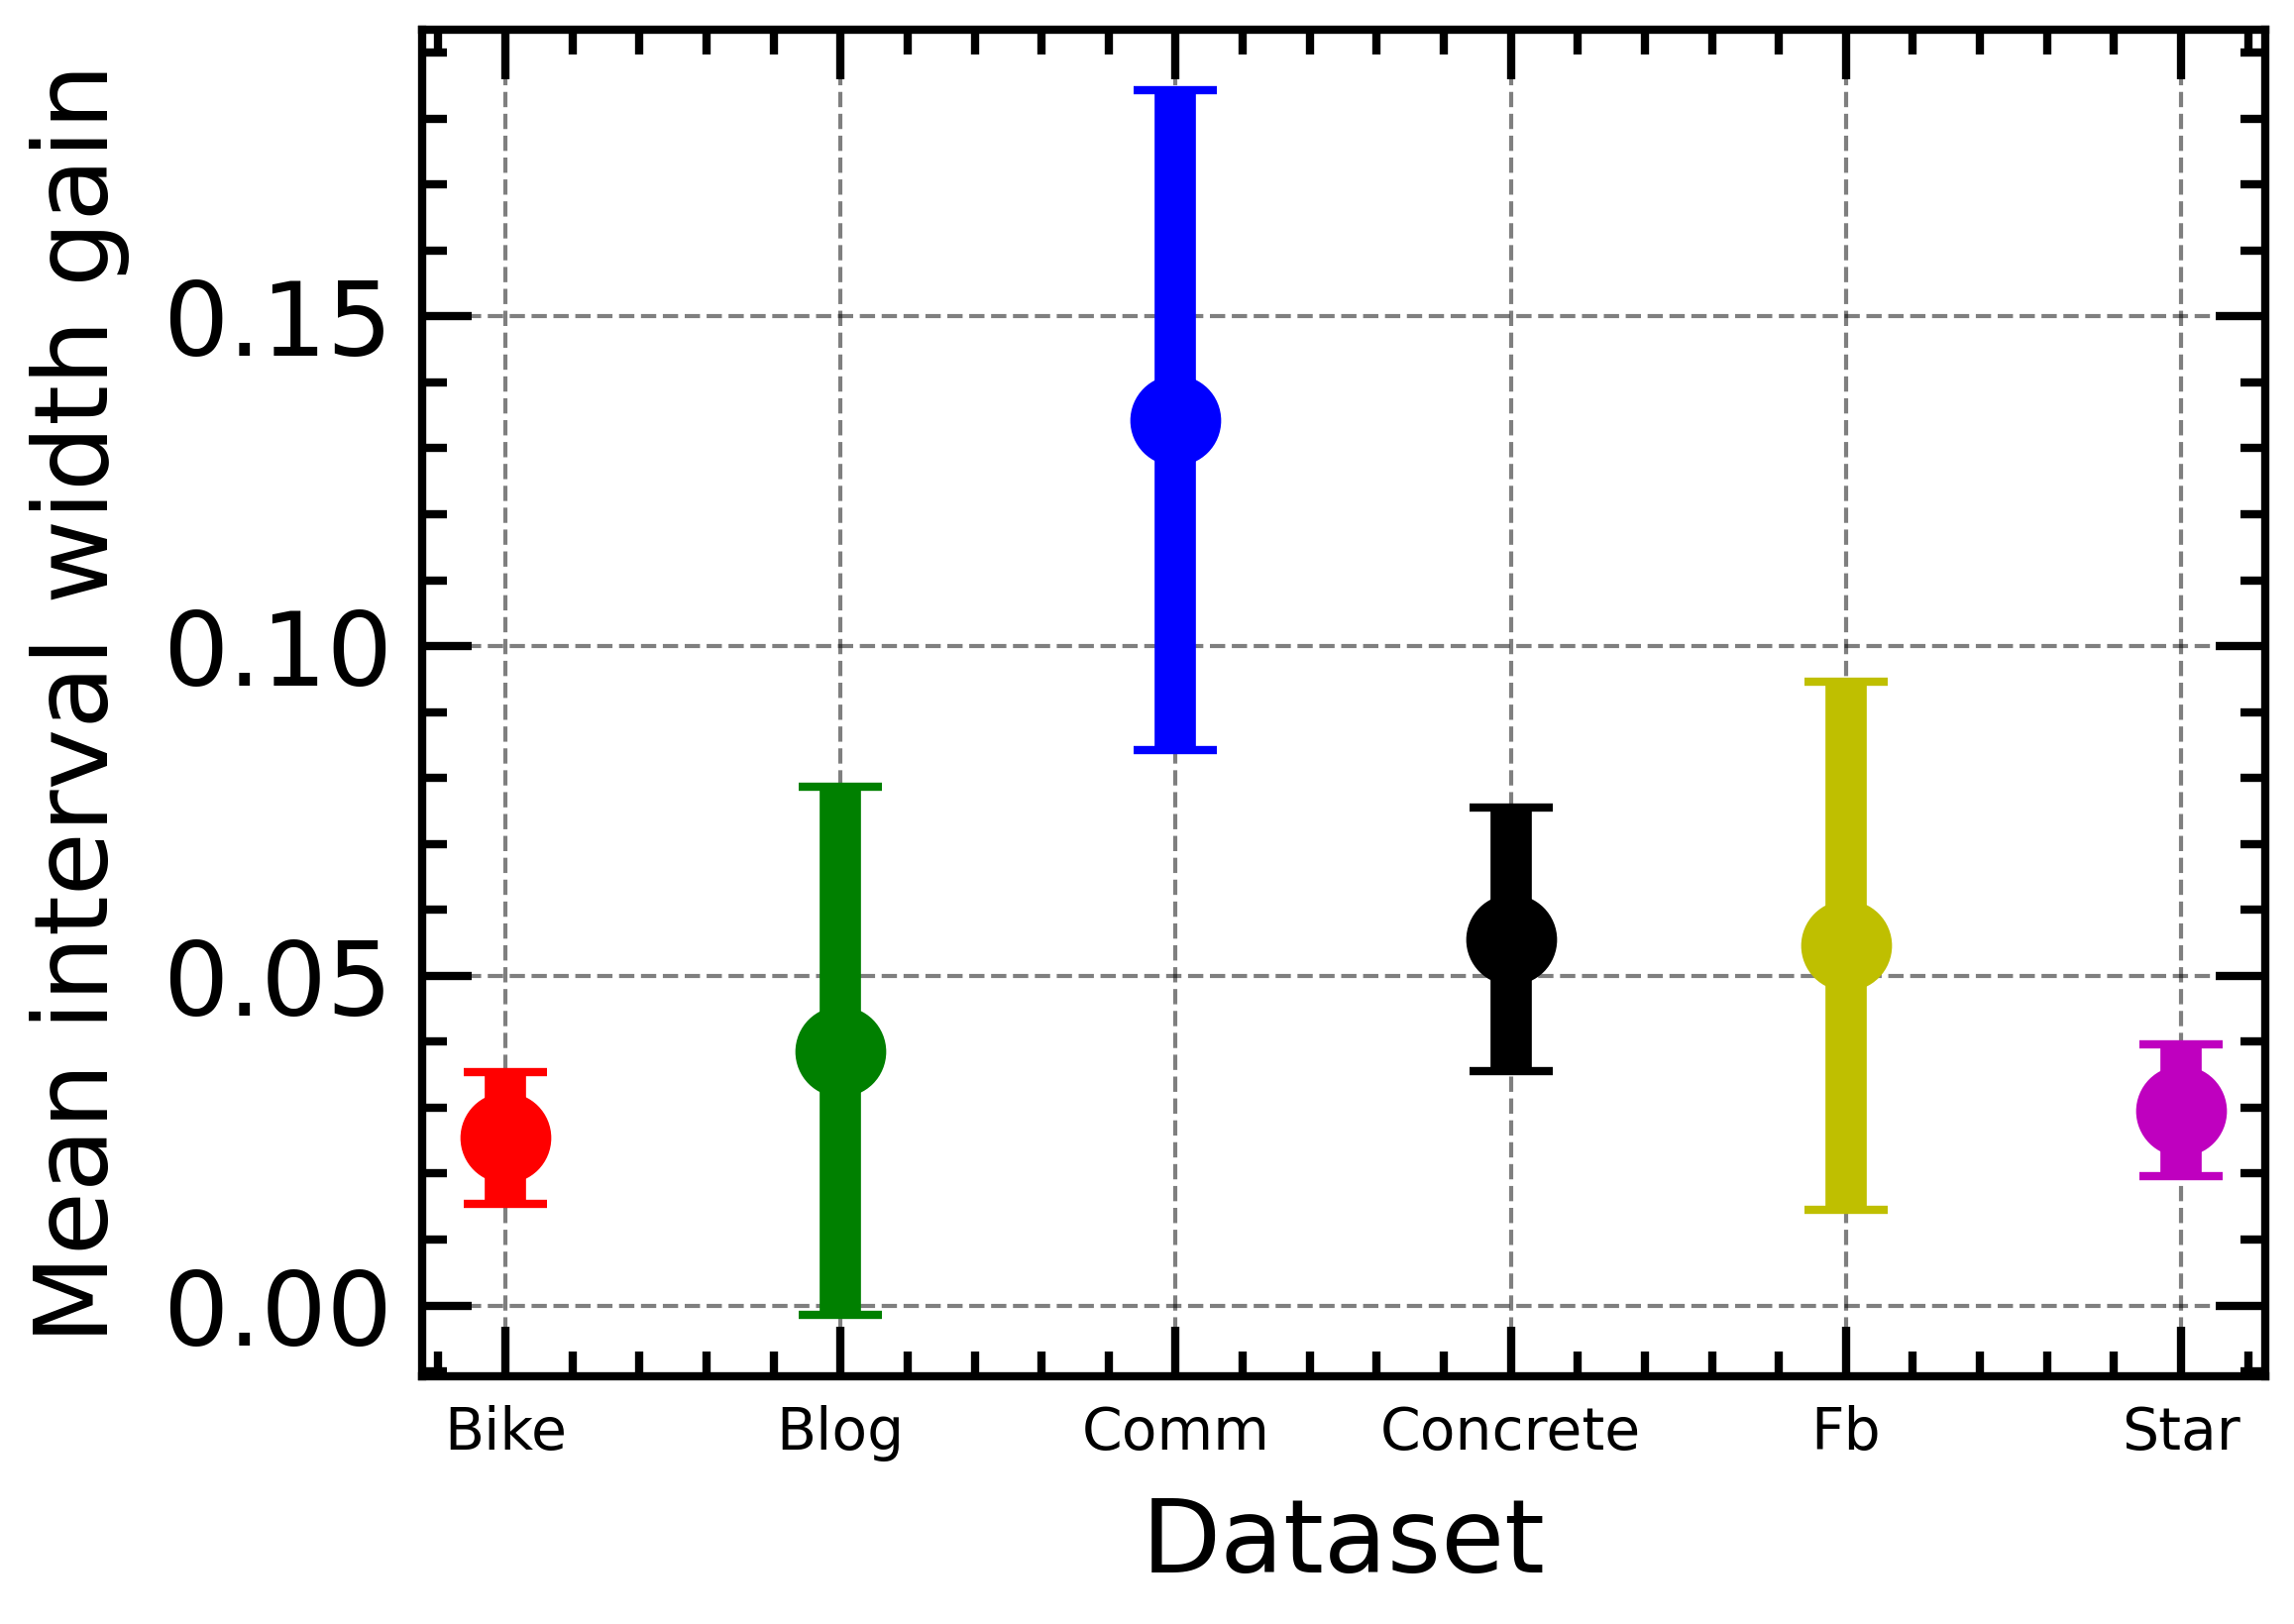

In [3]:
plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])
SMALL_SIZE = 12.5
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title


datasets = ["Bike", "Blog", "Comm", "Concrete", "Fb", "Star"]

methods = ['Interval diffs']

colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']


plt.figure(figsize=(4,3))

means = overall_mean
stds = mean_upper
x_val=0
for i, method in enumerate(means):
    # Plot error bars
    plt.errorbar(x = x_val, 
                 y = means[i], 
                 yerr = round(mean_upper[i]-means[i],2), 
                 label=method, 
                 marker='o', 
                 markersize=10, 
                 linestyle="", 
                 color=colors[i],
                 capsize=5, 
                 elinewidth=5)
    
    x_val+=0.01

plt.xticks([0, 0.01, 0.02, 0.03, 0.04, 0.05], datasets)
plt.xlabel('Dataset')
plt.ylabel('Mean interval width gain')
plt.savefig('../figures/interval_robustness.pdf', bbox_inches='tight')
plt.show()
